In [1]:
import numpy as np
import seaborn as sb
import pandas
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import torch
import time
from torchviz import make_dot
import random

# Part1


In [2]:
def relu(X):
    return np.maximum(X, 0)

def relu_derivative(X):
    return 1. * (X>0)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1. -tanh(X)**2)

def logistic(X):
    return (1.0/(1.0 + np.exp(-X)))

def logistic_derivative(X):
    return (logistic(X) * (1.0-logistic(X)))

def actv_func(X):
    return 

In [3]:
# create a multi-layer neural network
def create_model(X, hidden_nodes, output_dim=2, activation_function = "relu", hidden_layers_num = 2):
     
    assert len(hidden_nodes) == (hidden_layers_num-1), \
        "Number of hidden nodes should be equal to number of hidden layers"
    
    # this will hold a dictionary of layers
    model = {}
    model['activation_function'] = activation_function
    # input dimensionality
    input_dim = X.shape[1]

    weight = {}
    bias = {}

    # initialize the weights and bias
    for i in range(hidden_layers_num):
        if i == 0:
            weight[i] = np.random.randn(input_dim, hidden_nodes[i])
            bias[i] = np.zeros((1,hidden_nodes[i]))
        
        elif i == hidden_layers_num-1:
            weight[i] = np.random.randn(hidden_nodes[i-1], output_dim)
            bias[i] = np.zeros((1,output_dim))
        
        else:
            weight[i] = np.random.randn(hidden_nodes[i-1], hidden_nodes[i])
            bias[i] = np.zeros((1,hidden_nodes[i]))
    
    model['weight'] = weight
    model['bias'] = bias

    return model

In [4]:
# create a forward pass for multi layer neural network
def forward(model, x, activation_function = "relu", hidden_layers_num = 2):
    # this will hold the activation values
    activations = {}
    activations[0] = x

    # number of layers in the model
    L = hidden_layers_num + 1

    # perform the forward pass
    for i in range(1, L):
        if i == L-1:
            activations[i] = np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1]
        else:
            if activation_function == "relu":
                activations[i] = relu(np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1])
            elif activation_function == "tanh":
                activations[i] = tanh(np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1])
            elif activation_function == "logistic":
                activations[i] = logistic(np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1])
            else:
                print("Please enter a valid activation function")
                sys.exit()
    
    return activations

In [ ]:
# create a function for calculatin multi layer regression loss
def loss(model, x, y, activation_function = "relu", hidden_layers_num = 2):
    # get the number of examples
    m = x.shape[0]
    # perform the forward pass
    activations = forward(model, x, activation_function, hidden_layers_num)
    # number of layers in the model
    L = hidden_layers_num + 1
    # get the last activation
    yhat = activations[L-1]
    # calculate the loss
    loss = np.sum((yhat - y)**2) / (2*m)
    
    return loss

In [5]:
# create a function for calculating multi layer regression loss with l2 regularization
def calculate_loss(model, x, y, activation_function = "relu", hidden_layers_num = 2, reg_lambda = 0.01, regularization=False):
    # number of layers in the model
    L = hidden_layers_num + 1
    
    # number of training samples
    m = x.shape[0]
    
    # forward pass
    activations = forward(model, x, activation_function, hidden_layers_num)
    
    if regularization:
        # calculate the loss
        loss = 0.5 * np.sum((activations[L-1] - y)**2)/m
        
        # add regularization term to loss (optional)
        for i in range(L-1):
            loss += 0.5 * reg_lambda * np.sum(model['weight'][i]**2)

    else:
        # calculate the loss
        loss = 0.5 * np.sum((activations[L-1] - y)**2)/m
    
    return loss

In [6]:
# create a function for backpropagation for multi layer neural network with l2 regularization
def backward(model, x, y, activations, activation_function = "relu", hidden_layers_num = 2, reg_lambda = 0.01, regularization = False):
    # number of layers in the model
    L = hidden_layers_num + 1
    
    # number of training samples
    m = x.shape[0]
    
    # backward pass
    # first, calculate the gradient at the output layer
    grad = {}
    grad[L-1] = (activations[L-1] - y)/m
    
    # next, calculate the gradient for the rest of the layers
    for i in range(L-2, 0, -1):
        if activation_function == "relu":
            grad[i] = np.dot(grad[i+1], model['weight'][i].T) * relu_derivative(activations[i])
        elif activation_function == "tanh":
            grad[i] = np.dot(grad[i+1], model['weight'][i].T) * tanh_derivative(activations[i])
        elif activation_function == "logistic":
            grad[i] = np.dot(grad[i+1], model['weight'][i].T) * logistic_derivative(activations[i])
        else:
            print("Please enter a valid activation function")
            sys.exit()
    
    # calculate the gradient for the weights and bias
    grad_weight = {}
    grad_bias = {}

    if regularization:
        for i in range(L-1):
            if i == 0:
                grad_weight[i] = np.dot(x.T, grad[i+1]) + reg_lambda * model['weight'][i]
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
            else:
                grad_weight[i] = np.dot(activations[i].T, grad[i+1]) + reg_lambda * model['weight'][i]
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)

    else:
        for i in range(L-1):
            if i == 0:
                grad_weight[i] = np.dot(x.T, grad[i+1])
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
            else:
                grad_weight[i] = np.dot(activations[i].T, grad[i+1])
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
    
    return grad_weight, grad_bias

In [7]:
# create a function for training the multi layer neural network
def train(model, x, y, learning_rate = 0.01, activation_function = "relu", hidden_layers_num = 2, reg_lambda = 0.01, epochs = 10000, sgd = True, regularization=True):
    # number of layers in the model
    L = hidden_layers_num + 1

    previous_loss = float('inf')
    losses = []

    current_iter = 0
    
    # gradient descent
    for i in range(epochs):
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False)
            input_data = x[randinds,:]
            target = y[randinds]
        else:
            input_data = x
            target = y
        # forward pass
        activations = forward(model, input_data, activation_function, hidden_layers_num)
        # backward pass
        grad_weight, grad_bias = backward(model, input_data, target, activations, activation_function, hidden_layers_num, reg_lambda, regularization=regularization)
        
        # update the weights and bias
        for j in range(L-1):
            model['weight'][j] -= learning_rate * grad_weight[j]
            model['bias'][j] -= learning_rate * grad_bias[j]

        if i % 1000 == 0:
            # calculate the loss
            loss = calculate_loss(model, x, y, activation_function, hidden_layers_num, reg_lambda, regularization=regularization)
            losses.append(loss)
            print("Loss after iteration %i: %f" %(i, loss))
            # very crude method to break optimization
            if np.abs(np.logaddexp(previous_loss-loss)/previous_loss) < 0.0001:
                break
            previous_loss = loss
        
        current_iter += 1

    current_iter += 1
    
    return model, losses, current_iter

### create data for regression

In [8]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

## Experiment


In [ ]:
def experiment(x, y, config):
    # get configuration parameters
    learning_rate = config['learning_rate']
    activation_function = config['activation_function']
    hidden_layers_num = config['hidden_layers_num']
    hidden_nodes_num = config['hidden_nodes_num']
    reg_lambda = config['reg_lambda']
    epochs = config['epochs']
    sgd = config['sgd']
    regularization = config['regularization']
    output_dim = y.shape[1]


    # create a model
    model = create_model(x, hidden_nodes_num, 
                        output_dim, activation_function, 
                        hidden_layers_num = hidden_layers_num)
    
    # train the model
    model, losses, last_iter = train(model, x, y, 
                                    learning_rate = learning_rate, 
                                    activation_function = activation_function, 
                                    hidden_layers_num = hidden_layers_num, 
                                    reg_lambda = reg_lambda, 
                                    epochs = epochs)

    return model, losses, last_iter

### 1. 8-neurons

In [ ]:
result = {}

config1 = {}
config1['learning_rate'] = 0.001
config1['activation_function'] = "relu"
config1['hidden_layers_num'] = 2
config1['hidden_nodes_num'] = [8]
config1['reg_lambda'] = 0.01
config1['epochs'] = 100000
config1['sgd'] = False
config1['regularization'] = False



for i in range(10):
    model, losses, last_iter = experiment(X, y, config1)
    result[i] = {}
    result[i]['model'] = model
    result[i]['losses'] = losses
    result[i]['last_iter'] = last_iter

In [9]:
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 2
# Number of hidden layer nodes
hidden_nodes_num = [8]
# Number of iteration
epochs = 100000
# SGD or not
sgd = False
# Regularization or not
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)
# train it
model, losses = train(model,X, y, epochs = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num, sgd=sgd, regularization=regularization)

# determine predictions of the trained model
activations = forward(model, X, activation_function)

Loss after iteration 0: 924.977397
Loss after iteration 1000: 19.304780
Loss after iteration 2000: 15.792152
Loss after iteration 3000: 13.430319


/tmp/ipykernel_1140/4191090094.py:35: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


Loss after iteration 4000: 11.602966
Loss after iteration 5000: 9.761364
Loss after iteration 6000: 8.639287
Loss after iteration 7000: 6.399583
Loss after iteration 8000: 6.022893
Loss after iteration 9000: 5.439568
Loss after iteration 10000: 5.860172
Loss after iteration 11000: 5.220617
Loss after iteration 12000: 5.236990
Loss after iteration 13000: 5.208734
Loss after iteration 14000: 5.055299
Loss after iteration 15000: 5.012858
Loss after iteration 16000: 5.014618
Loss after iteration 17000: 4.884390
Loss after iteration 18000: 4.892657
Loss after iteration 19000: 5.045017
Loss after iteration 20000: 5.308501
Loss after iteration 21000: 4.953424
Loss after iteration 22000: 4.781010
Loss after iteration 23000: 4.904404
Loss after iteration 24000: 4.868249
Loss after iteration 25000: 4.898622
Loss after iteration 26000: 4.908307
Loss after iteration 27000: 4.861322
Loss after iteration 28000: 4.799032
Loss after iteration 29000: 4.761692
Loss after iteration 30000: 4.772741
Loss a

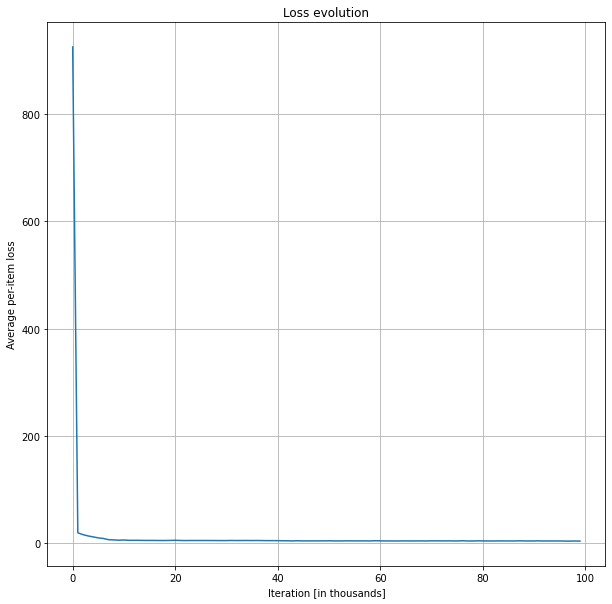

In [10]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 1-discussion
this version converges at 49000 iteration for loss 2.89

## 2. 4 + 4 neurons for the three-layer version

In [11]:
# training set size
num_examples = len(X) 
# output layer dimensionality
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 3
# Number of hidden layer nodes
hidden_nodes_num = [4,4]
# Number of iteration
epochs = 100000
# Regularization?
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, epochs = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num)

# determine predictions of the trained model
activations = forward(model, X, activation_function)

Loss after iteration 0: 998.183984
Loss after iteration 1000: 21.674067
Loss after iteration 2000: 27.437504


/tmp/ipykernel_1140/4191090094.py:35: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


Loss after iteration 3000: 13.011478
Loss after iteration 4000: 13.524574
Loss after iteration 5000: 14.327524
Loss after iteration 6000: 13.769401
Loss after iteration 7000: 10.887589
Loss after iteration 8000: 8.809183
Loss after iteration 9000: 13.495600
Loss after iteration 10000: 9.177315
Loss after iteration 11000: 19.063544
Loss after iteration 12000: 8.434392
Loss after iteration 13000: 8.375812
Loss after iteration 14000: 11.895343
Loss after iteration 15000: 8.622223
Loss after iteration 16000: 9.641417
Loss after iteration 17000: 8.332308
Loss after iteration 18000: 8.814148
Loss after iteration 19000: 10.882160
Loss after iteration 20000: 7.996634
Loss after iteration 21000: 10.501195
Loss after iteration 22000: 18.639625
Loss after iteration 23000: 8.280483
Loss after iteration 24000: 9.580519
Loss after iteration 25000: 12.927619
Loss after iteration 26000: 7.614195
Loss after iteration 27000: 9.831494
Loss after iteration 28000: 10.194709
Loss after iteration 29000: 7.82

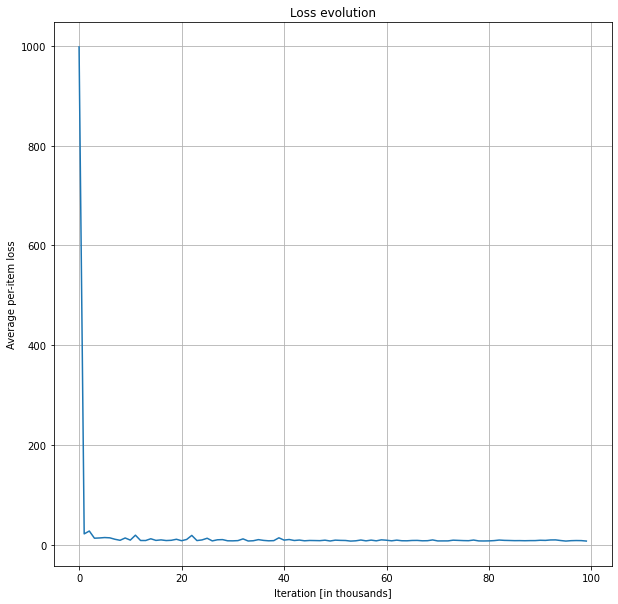

In [12]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 2-discussion
this version converges at 74000 iteration for loss 4.94

## 3. 16 neurons for the two-layer version

In [13]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
        
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 2
# Number of hidden layer nodes
hidden_nodes_num = [16]
# Number of iteration
epochs = 100000
# Regularization?
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, epochs = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num)

# determine predictions of the trained model
activations = forward(model, X, activation_function)

Loss after iteration 0: 1113.096033
Loss after iteration 1000: 22.248717
Loss after iteration 2000: 10.400888
Loss after iteration 3000: 6.812830


/tmp/ipykernel_1140/4191090094.py:35: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


Loss after iteration 4000: 5.016379
Loss after iteration 5000: 3.704368
Loss after iteration 6000: 2.931010
Loss after iteration 7000: 2.723615
Loss after iteration 8000: 2.471534
Loss after iteration 9000: 2.600908
Loss after iteration 10000: 2.223538
Loss after iteration 11000: 2.176649
Loss after iteration 12000: 2.120522
Loss after iteration 13000: 1.976310
Loss after iteration 14000: 1.932605
Loss after iteration 15000: 1.961794
Loss after iteration 16000: 1.866037
Loss after iteration 17000: 1.811432
Loss after iteration 18000: 1.822881
Loss after iteration 19000: 1.782247
Loss after iteration 20000: 1.761960
Loss after iteration 21000: 1.820679
Loss after iteration 22000: 1.761956
Loss after iteration 23000: 1.687646
Loss after iteration 24000: 1.707955
Loss after iteration 25000: 1.666534
Loss after iteration 26000: 1.655190
Loss after iteration 27000: 1.678678
Loss after iteration 28000: 1.690375
Loss after iteration 29000: 1.642581
Loss after iteration 30000: 1.690910
Loss af

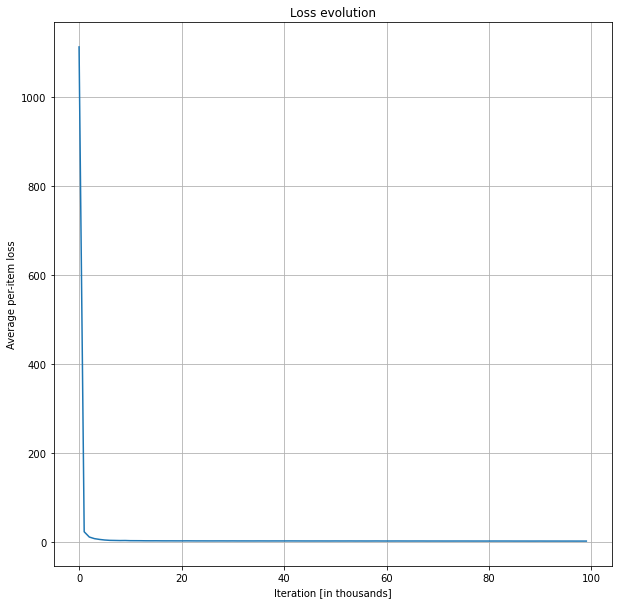

In [14]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 3-discussion
this version converges at 47000 iteration for loss 1.38

## 4. (8 + 8) neurons for the three-layer version

In [15]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
        
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 3
# Number of hidden layer nodes
hidden_nodes_num = [8,8]
# Number of iteration
epochs = 100000
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, epochs = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num)

# determine predictions of the trained model
activations = forward(model, X, activation_function)

Loss after iteration 0: 924.414361
Loss after iteration 1000: 10.573232
Loss after iteration 2000: 5.719583


/tmp/ipykernel_1140/4191090094.py:35: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


Loss after iteration 3000: 4.370760
Loss after iteration 4000: 7.218531
Loss after iteration 5000: 4.881546
Loss after iteration 6000: 2.196413
Loss after iteration 7000: 6.040881
Loss after iteration 8000: 2.535569
Loss after iteration 9000: 2.300775
Loss after iteration 10000: 4.391369
Loss after iteration 11000: 2.282035
Loss after iteration 12000: 1.956039
Loss after iteration 13000: 3.141302
Loss after iteration 14000: 1.675894
Loss after iteration 15000: 2.168514
Loss after iteration 16000: 1.788159
Loss after iteration 17000: 2.417907
Loss after iteration 18000: 2.716688
Loss after iteration 19000: 2.662676
Loss after iteration 20000: 1.731877
Loss after iteration 21000: 2.424835
Loss after iteration 22000: 1.874443
Loss after iteration 23000: 1.751759
Loss after iteration 24000: 2.676472
Loss after iteration 25000: 1.667556
Loss after iteration 26000: 2.559360
Loss after iteration 27000: 1.830067
Loss after iteration 28000: 2.676892
Loss after iteration 29000: 1.656898
Loss aft

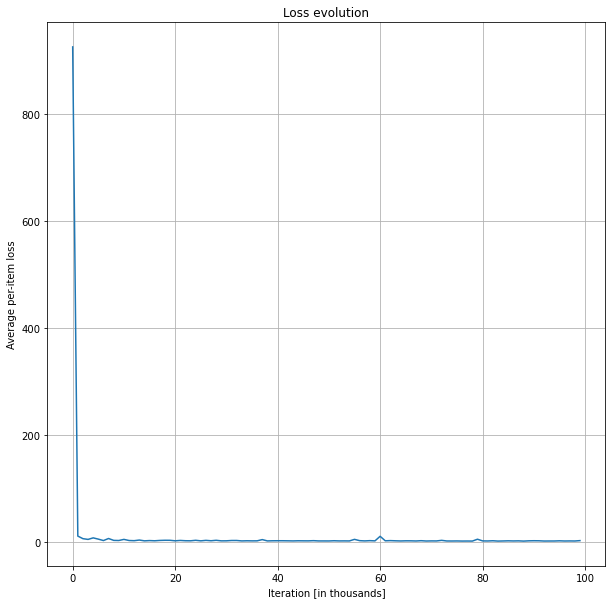

In [16]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 4-discussion
this version converges at 30000 iteration for loss 0.87

the model that has 8 neurons for each three hidden layers is the best model

# Bonus

In [20]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 1e-5
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 4
# Number of hidden layer nodes
hidden_nodes_num = [8,16,8]
# Number of iteration
epochs = 100000
regularization = False
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, epochs = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num)

# determine predictions of the trained model
activations = forward(model, X, activation_function, hidden_layers_num = hidden_layers_num)


Loss after iteration 0: 1225.693744
Loss after iteration 1000: 29.593110
Loss after iteration 2000: 13.512819


/tmp/ipykernel_1140/4191090094.py:35: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


Loss after iteration 3000: 9.218031
Loss after iteration 4000: 7.215168
Loss after iteration 5000: 6.375617
Loss after iteration 6000: 4.952786
Loss after iteration 7000: 4.528262
Loss after iteration 8000: 4.231590
Loss after iteration 9000: 3.750710
Loss after iteration 10000: 3.585141
Loss after iteration 11000: 3.211584
Loss after iteration 12000: 3.241918
Loss after iteration 13000: 3.617308
Loss after iteration 14000: 2.905295
Loss after iteration 15000: 2.756631
Loss after iteration 16000: 2.721191
Loss after iteration 17000: 2.591781
Loss after iteration 18000: 2.582936
Loss after iteration 19000: 2.540840
Loss after iteration 20000: 2.607151
Loss after iteration 21000: 2.552563
Loss after iteration 22000: 2.378535
Loss after iteration 23000: 2.698307
Loss after iteration 24000: 2.454296
Loss after iteration 25000: 2.448037
Loss after iteration 26000: 2.243621
Loss after iteration 27000: 2.213545
Loss after iteration 28000: 2.219594
Loss after iteration 29000: 2.326472
Loss aft

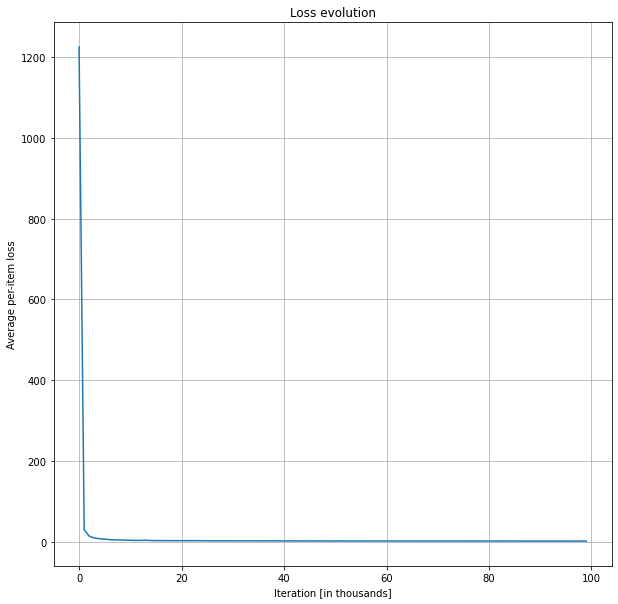

In [21]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

For bonus, the learning rate should be less then 1e-4. Becaouse it doesn not converge when the learning rate is larger than 1e-4.

# Part2 Pytorch version

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import time
import matplotlib.pyplot as plt

In [8]:
#if (torch.has_cuda): # do this for automatic switching

doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

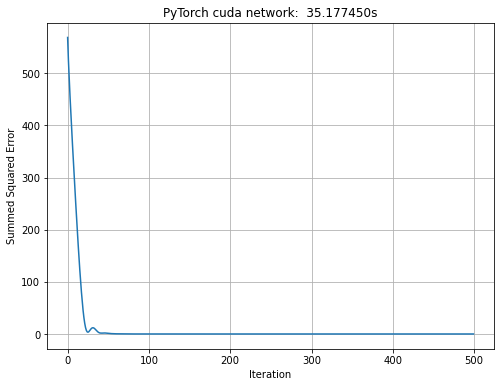

In [19]:
#if (torch.has_cuda): # do this for automatic switching
start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10000, 10
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)
opt = 'adam'

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# After constructing the model we use the .to() method to move it to the
# desired device.

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, H+10),
    nn.ReLU(),
    nn.Linear(H+10, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

model.to(device)


# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.

learning_rate = 1e-5
max_iterations = 10000
# l2_errors = np.zeros(max_iterations)
loss_func = nn.MSELoss(reduction="sum")
loss_array = []

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
if optim == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
elif optim == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)


for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    optimizer.zero_grad()
    y_pred = model(x) 
    
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_func(y_pred, y)
    loss.backward()
    optimizer.step()

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss_array.append(loss.item())


    # Calling the step function on an Optimizer makes an update to its parameters

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(loss_array)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

In [13]:
print(model)

Sequential(
  (0): Linear(in_features=1000, out_features=10000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10000, out_features=10010, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10010, out_features=10000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10000, out_features=10, bias=True)
)


In [14]:
x = torch.randn(512, 1000).requires_grad_(True).to(device)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("torchviz", format="png")
plt.figure(figsize=(10,20))
img = mpimg.imread('torchviz.png')
plt.imshow(img)
plt.show()

NameError: name 'make_dot' is not defined

In [ ]:
# if above not working ... conda install python-graphviz
